In [1]:
%matplotlib inline

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc
import os
import glob
import os.path as osp
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D

In [8]:
path = './train_images/'

In [9]:
class PlanktonDS(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, root, mode='train'):
        """ Intialize the dataset
        """
        self.filenames = []
        self.root = root
        self.mode = 'test'
        if self.mode == 'train':
            self.mode = 'train'
            self.masks = pd.read_csv('./train_onelabel.csv')
        #augmentation here....
        #self.transform = transforms.ToTensor()
        self.transform = transforms.Compose([
    transforms.Resize((50,50)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        filenames = glob.glob(osp.join(path, '*.jpg'))
        for fn in filenames:
            self.filenames.append(fn)
        self.len = len(self.filenames)
        
    def get_mask(self, ImageId):
        img_masks = self.masks.loc[self.masks['image'] == ImageId, 'class'].tolist()
        return img_masks
    
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image = Image.open(self.filenames[index])
        ImageId = self.filenames[index].split('/')[-1]
        if self.mode == 'train':
            mask = self.get_mask(ImageId)
        #augmentation here...
        return self.transform(image)

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [10]:
planktonimg = PlanktonDS(path, mode='train')
print(planktonimg.len)

24204


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


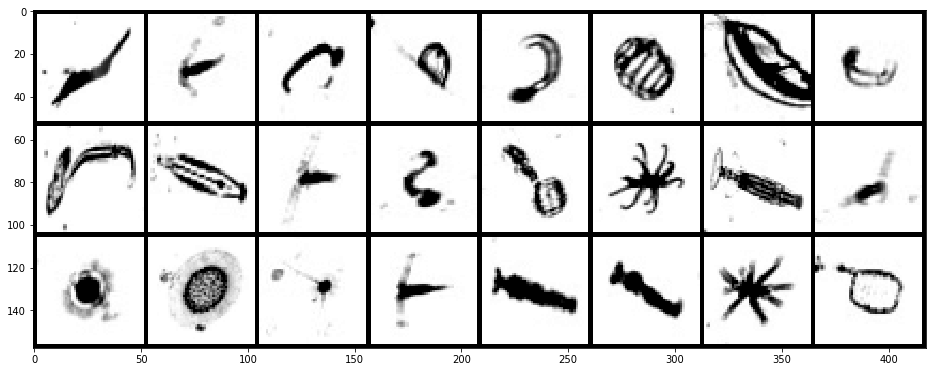

In [11]:
# Use the torch dataloader to iterate through the dataset
loader = D.DataLoader(planktonimg, batch_size=24, shuffle=False, num_workers=0)

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some images
dataiter = iter(loader)
images = dataiter.next()

# show images
plt.figure(figsize=(16,8))
imshow(torchvision.utils.make_grid(images))

In [12]:
masks = pd.read_csv('./train_onelabel.csv')
masks.head()

,image,class
0,132103.jpg,0
1,66467.jpg,0
2,9143.jpg,0
3,20630.jpg,0
4,33689.jpg,0


In [13]:
# Use the torch dataloader to iterate through the dataset
loader = D.DataLoader(planktonimg, batch_size=24, shuffle=False, num_workers=0)

train_len = int(0.7*planktonimg.len)
valid_len = planktonimg.len - train_len
train, valid = D.random_split(planktonimg, lengths=[train_len, valid_len])


In [14]:
# check lens of subset
len(train), len(valid)

(16942, 7262)

In [15]:
trainloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid, batch_size=4, shuffle=False, num_workers=2)

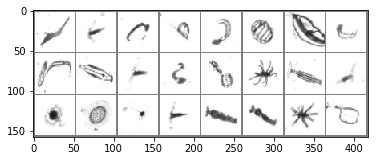

In [20]:
plimg = PlanktonDS(path, mode='train')
# Use the torch dataloader to iterate through the dataset
loader = D.DataLoader(plimg, batch_size=24, shuffle=False, num_workers=0)

# get some images
dataiter = iter(loader)
images = dataiter.next()

#show the images
imshow(torchvision.utils.make_grid(images))


Let us show some of the training images, for fun.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
not yet done... just copied




In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))